# Postprocessing Pipeline

---

This notebook shows our postprocessing pipeline for one example.

## Input

1. Input will be a list of arrays with shape 6x21. The list length will vary from song to song.

1. The arrays come from overlapping timeframes, so that data from array $a_0$ can still be found in arrays $a_1$ to $a_8$.

1. We don't know what data that is.

## Code

In [1254]:
# imports
import numpy as np
import pandas as pd
import IPython
import jams
import matplotlib.pyplot as plt
import seaborn as sns

In [1255]:
labeldata = np.load('../data/output/00_BN1-129-Eb_solo_mic_labels.npz')
jamsdata = jams.load('../data/raw/annotation/00_BN1-129-Eb_solo.jams')

In [1256]:
# positions 41-43 have two notes on the same string. this should not be possible?
# labeldata['arr_0'][41]

### Functions to get ground truth from jams files

In [1257]:
# getting midi info from jams file
def midi_info_from_jams(data: jams.JAMS):
    n = []
    s = []
    for string, i in enumerate(data.annotations['note_midi']):
        for j in i['data']:
            n.append(j[:-1])        # NOTES PLAYED
            s.append(string)        # STRINGS USED

    return s, n

In [1258]:
# adding fret column to notes_played_df
def find_frets_from_jams(notes_played, strings_used):
    tuning = [40, 45, 50, 55, 59, 64]
    notes = [n[2] for n in np.round(notes_played, 0)]
    fret = []
    for idx, i in enumerate(notes):
        if strings_used[idx] < 4:
            fret.append(int(notes[idx] - (40 + strings_used[idx] * 5)))
        elif strings_used[idx] >= 4:
            fret.append(int(notes[idx] - (39 + strings_used[idx] * 5)))
    
    return fret

In [1259]:
# get midi info
strings_used, notes_played = midi_info_from_jams(jamsdata)

# build dataframe
ground_truth_df = pd.DataFrame(notes_played, columns=['time', 'dur', 'midi'])

# adding string information
ground_truth_df['string'] = strings_used

# cleaning midi information
ground_truth_df['midi'] = ground_truth_df['midi'].round(0).astype(int)

# reformatting dataframe
ground_truth_df = ground_truth_df.sort_values(by='time')
ground_truth_df = ground_truth_df.reset_index().drop('index', axis=1)

# adding positional information
ground_truth_df['pos'] = list(range(ground_truth_df.shape[0]))

# adding frets
ground_truth_df['fret'] = find_frets_from_jams(notes_played, strings_used)

In [1260]:
ground_truth_df

,time,dur,midi,string,pos,fret
0,0.008544,0.174150,56,2,0,6
1,0.009973,0.214785,46,0,1,6
2,0.015052,0.168345,51,1,2,8
3,0.186957,0.301859,53,1,3,7
4,0.187705,0.290249,58,2,4,7
...,...,...,...,...,...,...
66,18.657478,0.731429,58,3,66,8
67,19.356367,0.214785,53,2,67,6
68,19.598136,0.487619,53,2,68,8
69,20.095959,0.098685,54,2,69,6


Testing convert to label

In [1279]:
# timeframe
fps = 43
start = 0
end = (1/fps) *9

labels = ground_truth_df[(ground_truth_df['time'] <= end) & (ground_truth_df['time'] > start)]
labels

,time,dur,midi,string,pos,fret
0,0.008544,0.174150,56,2,0,6
1,0.009973,0.214785,46,0,1,6
2,0.015052,0.168345,51,1,2,8
3,0.186957,0.301859,53,1,3,7
4,0.187705,0.290249,58,2,4,7


### Functions to build tabs from CNN output

In [1275]:
labeldata['arr_0'][0]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [1262]:
def find_frets(labels):

    tabs = []
    
    # get indices where labeldata is 1
    idx = np.where(labeldata['arr_0'] == 1)

    for position, window in enumerate(labels['arr_0']):
        for string, data in enumerate(window):
            idx = np.where(data[1:] == 1)
            if idx[0].size > 0:
                tabs.append([position, string, np.squeeze(idx[0][0])]) # [-1] is a quickfix for the error found above!

    tabs_df = pd.DataFrame(tabs, columns=['pos', 'string', 'fret'])

In [1263]:
find_frets(labeldata['arr_0'])

tabs_df.head(10)

,pos,string,fret
0,0,0,6
1,0,1,6
2,0,2,6
3,1,0,6
4,1,1,6
5,1,2,6
6,2,0,6
7,2,1,6
8,2,2,6
9,3,0,6


In [1264]:
def group_positions(data):
    """Groups a list of lists by the first value in each nested list.\n
    E.g. the array\n\t[[0, 1, 1], [0, 2, 2], [1, 3, 3]]\nwill be converted to\n
    \t[[[0, 1, 1], [0, 2, 2]], [[1, 3, 3]]]

    Args:
        data (list): a 2D list

    Returns:
        list: The transformed list
    """

    data = list(data)

    r = []
    for idx, t in enumerate(data):
        if idx == 0: 
            r.append([t])
        else:
            if t[0] == tabs[idx-1][0]:
                r[-1].insert(-1, t)
            else:
                r.append([t])
    
    return r

In [1265]:
# 1. group data per position
tabs_collected = group_positions(tabs)

In [1266]:
# 2. check whether item is also in previous window
#    convert list to np.array and use np.where to get the indices
# 3. if so, remove it.

# go through all entries
def clean_tabs(data):

    r = []
    # new positions
    pos_new = 0
    
    for idx, item in enumerate(data):

        # get current item without index
        item_curr = [i[1:] for i in item]

        # if it's the first entry, continue
        if idx == 0: 
            r.append([pos_new, [i for i in item_curr]])
            pos_new += 1
        # go through every item in entries
        else:
            # get previous item
            item_prev = [i[1:] for i in data[idx-1]]

            # clean current item
            item_clean = [i for i in item_curr if not i in item_prev]

            # remove duplicates
            if item_clean:
                pos_new += 1
                r.append([pos_new, item_clean])
            
            else: continue
    
    return r
    
tabs_cleaned = clean_tabs(tabs_collected)

In [1267]:
# save output in dataframe
tabs_clean_df = pd.DataFrame(tabs_cleaned, columns=['pos', 'string'])

In [1268]:
# explode positions
tabs_clean_df = tabs_clean_df.explode('string')

In [1269]:
# expand string, fret lists into two columns
tabs_clean_df['fret'] = [tabs_clean_df['string'].values[i][1] for i in range(tabs_clean_df.shape[0])]
tabs_clean_df['string'] = [tabs_clean_df['string'].values[i][0] for i in range(tabs_clean_df.shape[0])]

# reset index
tabs_clean_df = tabs_clean_df.reset_index().drop('index', axis=1)

In [1270]:
tabs_clean_df

,pos,string,fret
0,0,1,6
1,0,2,6
2,0,0,6
3,2,2,8
4,2,1,8
...,...,...,...
56,50,4,1
57,51,3,3
58,52,2,3
59,53,2,4


In [1276]:
def plot_tabs(data, idx_string, idx_fret, idx_pos):

    fig, ax = plt.subplots(figsize=(25, 6))
    tab_fig = sns.scatterplot(data=data, x='pos', y='string', marker="x", color='white', ax=ax)

    # rename yticks to string labels
    tab_fig.axes.set_yticks(list(range(6)))
    tab_fig.set_yticklabels(['E', 'A', 'D', 'G', 'H', 'e'])

    # remove xticks
    tab_fig.set_xticks([])

    # relabel x and y
    tab_fig.set_ylabel('String', size='large')
    tab_fig.set_xlabel("")

    # remove spines
    sns.despine(top=True, bottom=True, left=False, right=False)

    # add grid
    tab_fig.grid(which='major', axis='y', linestyle='-', color='gray')

    # add frets
    for note in data.values:
        tab_fig.annotate(text=str(int(note[idx_fret])), xy=(note[idx_pos], note[idx_string]-0.08), size='large', color="red") # can throw a FutureWarning: triggered by numpy. nothing much we can do about it.

### Compare ground truth to post processing

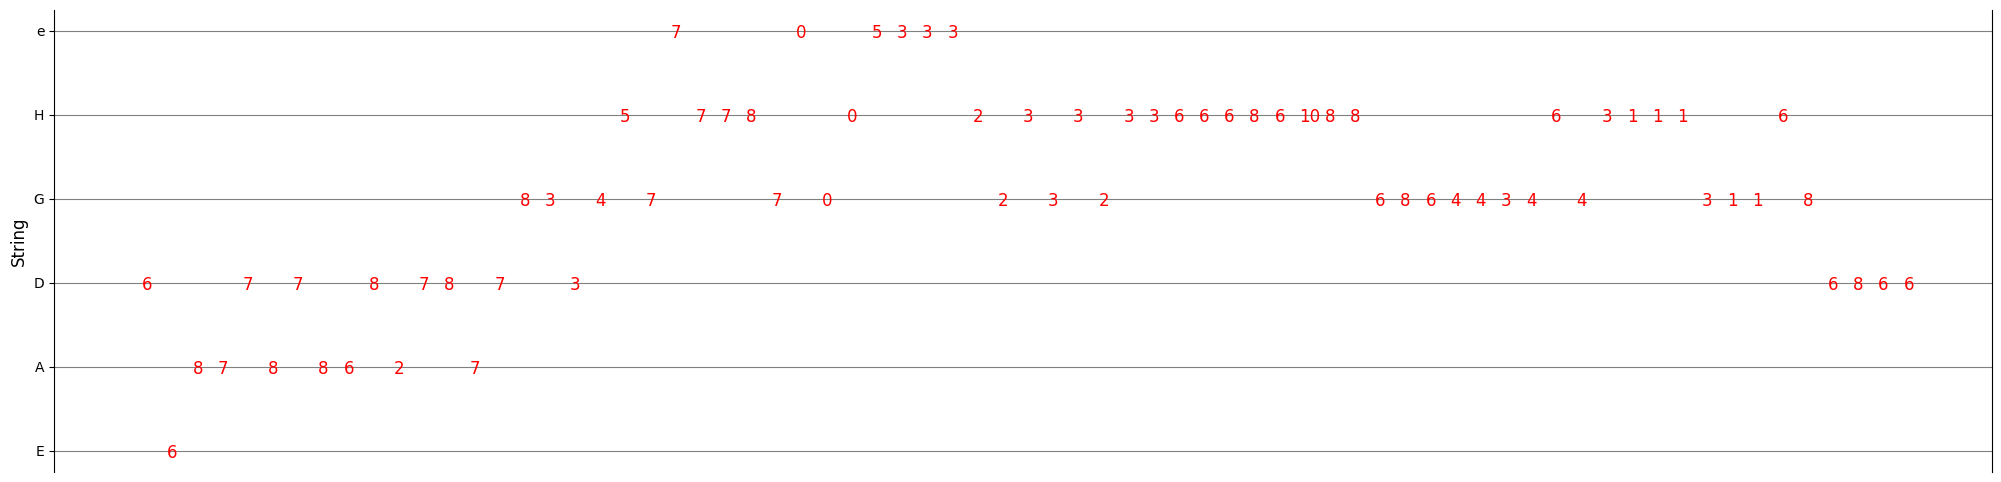

In [1277]:
plot_tabs(ground_truth_df, idx_string=3, idx_pos=4, idx_fret=5)

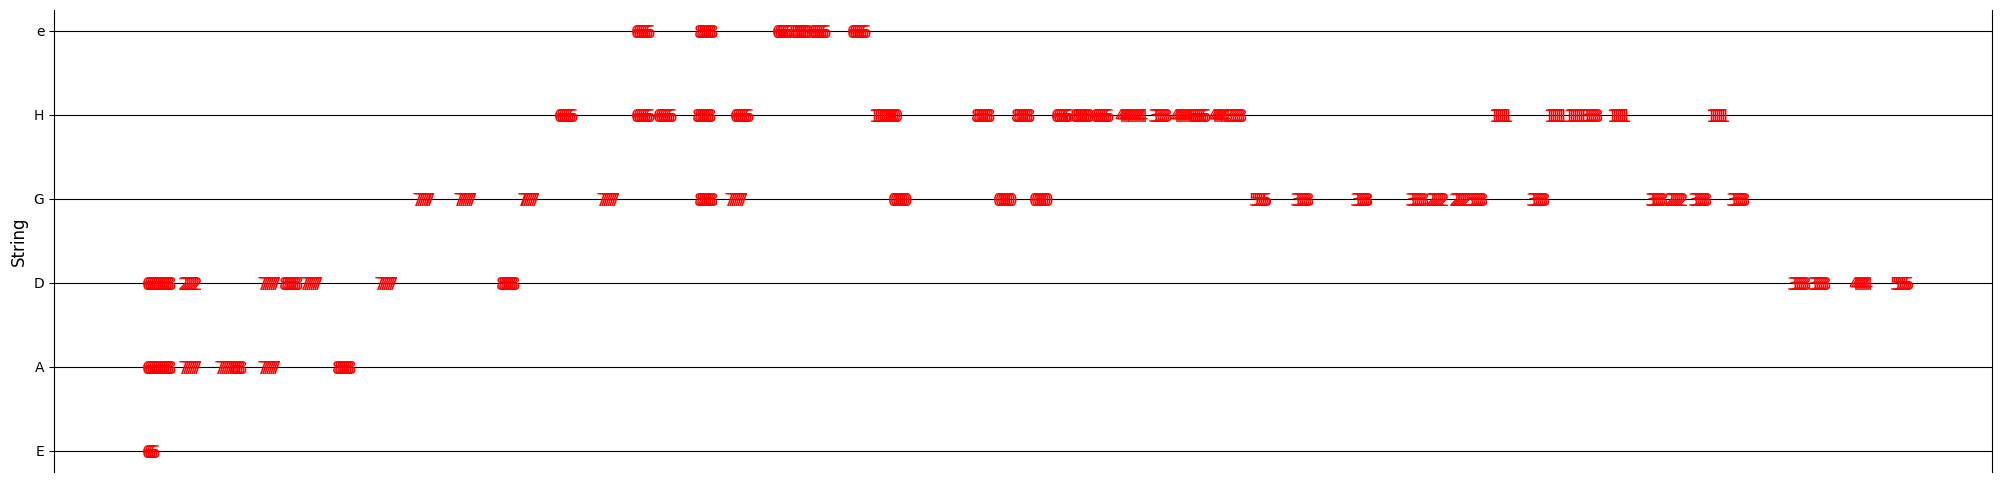

In [1273]:
plot_tabs(tabs_df, idx_string=1, idx_pos=0, idx_fret=2)